# Decision Trees

### Aims

By the end of this notebook you will be able to understand 

>* The Basics of Decision Trees
>* Gini Impurity
>* Classification Trees
>* Ensemble Models and Majority Voting


1. [**Setup**]

2. [**Basics of Decision Trees**]

3. [**Gini Impurity**]

4. [**Ensemble Models**]

5. [**Breast Cancer Data for Binary Example**]

In this WS we will be exploring the basics of decision trees. NOTE THAT, for the simplicity we did not use any data partitioning in below for toy data examples. But for the real data set, we have the data splitting procedure as a general procedure (Breast cancer data example). 

## Reminder on Terminology

- **Root node**: no incoming edge, zero, or more outgoing edges.

- **Internal node**: one incoming edge, two (or more) outgoing edges.

- **Leaf node**: each leaf node is assigned a class label if nodes are pure; otherwise, the class label is determined by majority vote.

- **Parent and child nodes**: If a node is split, we refer to that given node as the parent node, and the resulting nodes are called child nodes.

- Leaves are typically **drawn upside down**, so they are at the **bottom of the tree**. 

## CART

Scikit-Learn uses an optimised version of the Classification And Regression Tree (CART) algorithm.

- **Splitting Criterion**: Information gain
- **Number of Splits**: Binary
- **Independent Variables (Features)**: Continuous
- **Dependent variable**: Continuous or Categorical
- **Pruning**: Pre- & Post-pruning

**Notes**

"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now." https://scikit-learn.org/stable/modules/tree.html

## Information Gain

An algorithm starts at a tree root and then splits the data based on the feature $f$, that gives the largest information gain, $IG$

- To split using information gain relies on calculating the difference between an impurity measure of a parent node, $D_p$, and the impurities of its child nodes, $D_j$; information gain being high when the sum of the impurity of the child nodes is low.

- It is possible to maximise the information gain at each split using, $$IG(D_p, f) = I(D_p) - \sum_{i=1}^{m} \frac{N_j}{N_p} I(D_j)$$ where $I$ is the related impurity measure, $N_p$ is the total number of samples at the parent node and $N_j$ is the number of samples in the j'th child node.

Some algorithms, such as Scikit-learn's implimentation of CART, reduce the potential search space by implimenting binary trees:

- $IG(D_p, f) = I(D_p) - ( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$

- So to maximize the information gain, minimize the expression given in paranthesis $( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$. That exactly matches the minimization of impurity in a different way of representation. 

**NOTES**

- The CART algorithm is greedy - meaning it searches for the optimum split at each level. It does not check if this is the best split to improve impurity further down the tree.
- To find the optimal tree is known as an NP-Complete problem, meaning it is intractable even for small training sets
- Two impurity measures that are commonly used in binary decision trees are the gini impurity and entropy (log-loss) 

# 1. General Setup <a id='setup'></a>

## 1.1 Packages

Now lets load in the packages you wil need for this notebook.


In [60]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# sklearn modules list that might be useful, maybe you do not need to use all of them
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
#  from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# About Tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from re import search
import matplotlib as mpl

# For Breast cancer data 
from sklearn.datasets import load_breast_cancer

In [61]:
# Plotting defaults MIGHT BE modified
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

##  1.2 Palmer Data Set

In [62]:
# Install the data set
!pip install palmerpenguins

# Palmer Penguins Data
from palmerpenguins import load_penguins

# 2. PalmerPenguins Data <a id='DecTree'></a>

The "palmer penguins" dataset contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.

In [63]:
penguins = sns.load_dataset("penguins")
display(penguins.head())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Since there are some missing values, they should be removed first

In [64]:
# dropna values
penguins_rm = penguins.dropna()
display(penguins_rm.head())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [65]:
penguins_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


In [66]:
# Look at the summary of continuos variable
penguins_rm.describe().round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.00,333.00,333.00,333.00
mean,43.99,17.16,200.97,4207.06
std,5.47,1.97,14.02,805.22
min,32.10,13.10,172.00,2700.00
25%,39.50,15.60,190.00,3550.00
50%,44.50,17.30,197.00,4050.00
75%,48.60,18.70,213.00,4775.00
max,59.60,21.50,231.00,6300.00


#### Task 1 

Based on the given plot below, 

- Which species is easy to separate by looking at the plot ?
- Which set of features might be the good choices to use for a classification problem ?


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


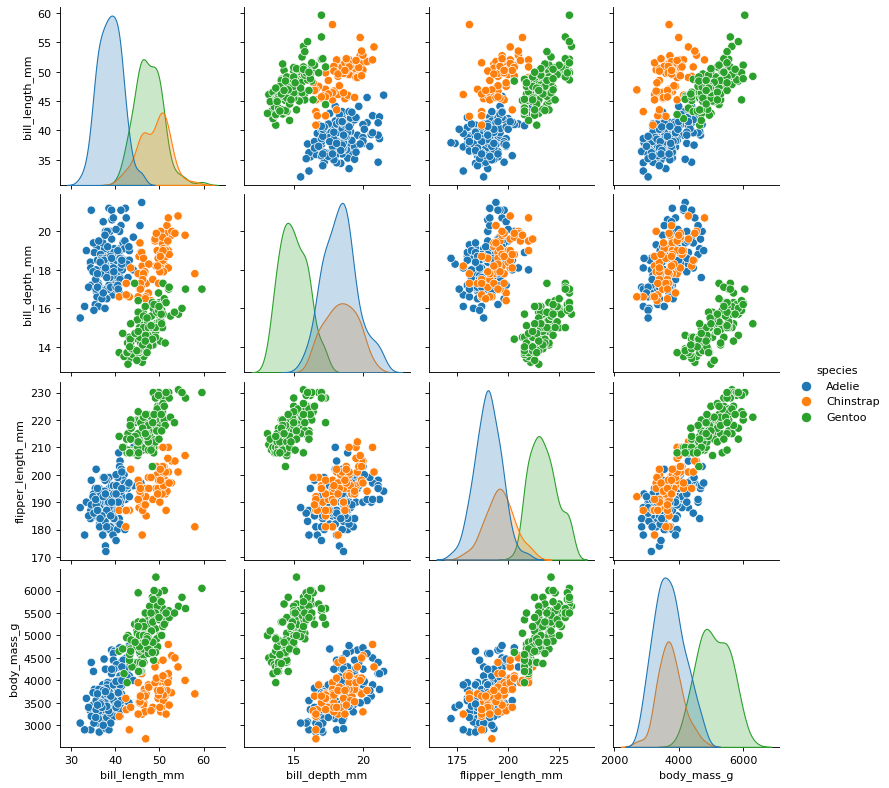

In [67]:
# Plotting the data set
sns.pairplot(data = penguins_rm, hue = "species")

### Task 2  

Consider the following decision tree fit on the penguins data, based on the selected predictors and try to answer the followings;

- What is the meaning of **max_depth** in the given code snippet ?

- Identify the predictor selected in the top/root node

- State the **type of nodes** illustrated below

- What is the meaning of the numbers inside of Value for each node ?

In [68]:
# Some selection on data
X = penguins_rm.drop(["island", "sex", "species", "body_mass_g"], axis=1)
y = penguins_rm.species 

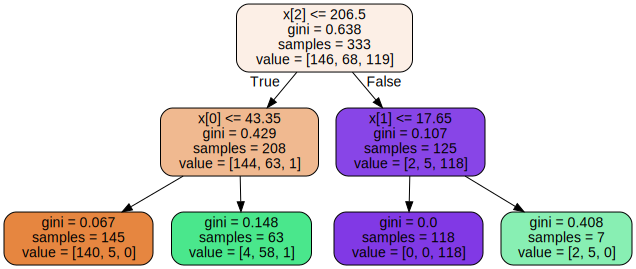

In [69]:
# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

max_depth = 2 means the decision tree will have a maximum depth of 2 levels.

Predictor selected in the top/root node:Since the decision tree was trained on features X (excluding "island", "sex", "species", and "body_mass_g") and target variable y (species), the top/root node would contain the predictor (feature) that best splits the dataset based on some criterion (usually Gini impurity or information gain). Unfortunately, without seeing the actual feature names, it's not possible to determine which predictor is selected in the top/root node.


The types of nodes illustrated are decision nodes and leaf nodes.
Decision nodes contain conditions based on features, and the tree branches out based on these conditions.
Leaf nodes represent the final outcome (prediction/classification).

The numbers inside Value for each node represent the distribution of samples from the training dataset that reach that particular node during the tree-building process.
For example, in the root node, the value = [146, 68, 119] means that there are 146 samples of one class, 68 samples of another class, and 119 samples of the third class.
This breakdown helps understand how the decision tree partitions the data into classes at each node.


### Task 3   <a id='gini'></a>

Related to the information gain calculation, we have Gini or entropy impurity

- Work out on the calculations of the related Gini index values in the leaf nodes for the given output

- Compare your results with your own calculations. Do they match exactly or not ?

- Update the above code snippet by changing the criterion from **Gini** to **Entropy** in the main function and get the similar output- Update the above code snippet by changing the criterion from **Gini** to **Entropy** in the main function and get the similar output

**RECALL**

- **Gini Index**: It is a measure of total variance across the $K$ classes, defined as follows:

$G = \sum_{k=1}^{K} \widehat{p}_{mk} (1 - \widehat{p}_{mk}) = 
1 - \sum_{k=1}^{K} \widehat{p}_{mk}^2$ 

where $\widehat{p}_{mk}$ is the proportion of training observations in the $m$'th region (belong to $mth$ node) coming from the $k$'th class.

- **Entropy**: It is an alternative to Gini Index and defined as; 

$D = - \sum_{k=1}^{K} \widehat{p}_{mk} \log \widehat{p}_{mk}$
where the range of $\widehat{p}_{mk}$ guarantees that $0 \leq - \widehat{p}_{mk} \log \widehat{p}_{mk}$.

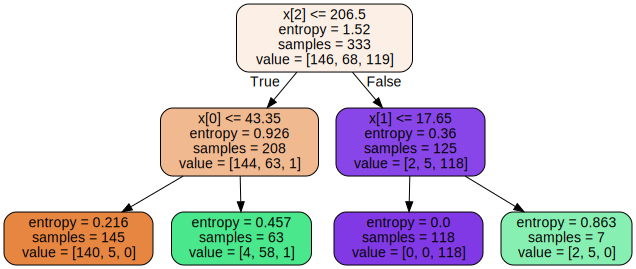

In [70]:
# Fitting DecisionTreeClassifier with criterion='entropy'
tree_clf_entropy = DecisionTreeClassifier(max_depth=2, criterion='entropy')
tree_clf_entropy.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data_entropy = export_graphviz(
    tree_clf_entropy,
    rounded=True,
    filled=True
)

# For plotting simply
import graphviz 
graph_entropy = graphviz.Source(tree_data_entropy) 
graph_entropy

### Task 4  

What is the accuracy of the fitted decision tree above over the 5-fold CV? 



In [71]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(tree_clf_entropy, X, y, cv=5)

# Calculate the mean accuracy
mean_accuracy = scores.mean()

print("Mean Accuracy:", mean_accuracy)


Mean Accuracy: 0.945906829488919


**The mean accuracy of the fitted decision tree classifier over the 5-fold cross-validation is approximately 94.59%. This indicates that, on average, the classifier correctly predicts the species of penguins in the dataset with a high accuracy rate.**

### Task 5 

Play around some of the input arguments, such as

- `max_depth`

- `min_samples_split`

- `min_samples_leaf`

- `max_leaf_nodes`

- `min_impurity_decrease`

by changing their values

- Rerun different models with such selections and compare / observe their performances briefly

In [72]:
# Define a function to evaluate the decision tree classifier with different hyperparameters
def evaluate_model(**params):
    tree_clf = DecisionTreeClassifier(**params)
    scores = cross_val_score(tree_clf, X, y, cv=5)
    mean_accuracy = np.mean(scores)
    return mean_accuracy

# Define different values for hyperparameters
max_depth_values = [None,2, 5, 10]  # Varying max_depth
min_samples_split_values = [2, 5, 10]  # Varying min_samples_split
min_samples_leaf_values = [1, 2,5,7,10]  # Varying min_samples_leaf
max_leaf_nodes_values = [None, 10, 20, 30]  # Varying max_leaf_nodes
min_impurity_decrease_values = [0.0, 0.1, 0.2]  # Varying min_impurity_decrease

In [73]:
# Evaluate models with different hyperparameters and observe performances
for param_value in max_depth_values:
    accuracy = evaluate_model(max_depth=param_value)
    print(f"max_depth={param_value}: Mean Accuracy={accuracy:.4f}")

max_depth=None: Mean Accuracy=0.9578
max_depth=2: Mean Accuracy=0.9519
max_depth=5: Mean Accuracy=0.9639
max_depth=10: Mean Accuracy=0.9639


Increasing the max_depth increases the mean accuracy of the model. (upto 10)

In [74]:
for param_value in min_samples_leaf_values:
    accuracy = evaluate_model(min_samples_leaf=param_value)
    print(f"min_samples_leaf={param_value}: Mean Accuracy={accuracy:.4f}")

min_samples_leaf=1: Mean Accuracy=0.9608
min_samples_leaf=2: Mean Accuracy=0.9609
min_samples_leaf=5: Mean Accuracy=0.9579
min_samples_leaf=7: Mean Accuracy=0.9398
min_samples_leaf=10: Mean Accuracy=0.9308


mean Accuracy for min_sample_leaf_values increases upto 5 then decreases.

In [75]:
for param_value in max_leaf_nodes_values:
    accuracy = evaluate_model(max_leaf_nodes=param_value)
    print(f"max_leaf_nodes={param_value}: Mean Accuracy={accuracy:.4f}")

max_leaf_nodes=None: Mean Accuracy=0.9578
max_leaf_nodes=10: Mean Accuracy=0.9608
max_leaf_nodes=20: Mean Accuracy=0.9608
max_leaf_nodes=30: Mean Accuracy=0.9578


Why is the mean accuracy for none and leaf nodes 20, same?

In [76]:
for param_value in min_impurity_decrease_values:
    accuracy = evaluate_model(min_impurity_decrease=param_value)
    print(f"min_impurity_decrease={param_value}: Mean Accuracy={accuracy:.4f}")

min_impurity_decrease=0.0: Mean Accuracy=0.9639
min_impurity_decrease=0.1: Mean Accuracy=0.9368
min_impurity_decrease=0.2: Mean Accuracy=0.9368


Min_impurity_decrease has no effect on mean_accuracy

# 3. Ensemble I: Bagging  <a id='majVot'></a> 

A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. To apply bagging to decision trees, we simply construct

(i) decision trees using bootstrapped training sets,
(ii) take a majority vote of the resulting predictions.

- A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

- Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- Specifically, bagging is when sampling is produced with replacement, and without replacement being called pasting

- Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory

- Both bagging and pasting allow training to be sampled several times across multiple predictors, with bagging only allowing several samples for the same predictor

- Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers

- Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

For some details on sklearn, please see that webpage 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html




### Task 6  

Execute the following code and try to answer the followings:

- What is the predicted class labels based on given Bagging model, using the same predictors that we used in Exercise 2

- How do you predict a new data having $(bill\_length\_mm,bill\_depth\_mm,flipper\_length\_mm)$ = (15.6, 34.7, 185.4) ? 

In [77]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10, random_state=42).fit(X, y)

We can use the predict method of the trained classifier

In [78]:
from sklearn.ensemble import BaggingClassifier

# Train the Bagging classifier
clf = BaggingClassifier(n_estimators=10, random_state=42).fit(X, y)

# Define new data point
new_data_point = [[15.6, 34.7, 185.4]]

# Predict the class labels for the new data point
predicted_labels = clf.predict(new_data_point)

print(predicted_labels)


['Adelie']


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


---

### Task 7  

Based on the above fitted model,

1. Calculate the out-of-bag score

2. Examine the impact of `n_estimators` by using different values in $(1, 100, 1000)$

3. Compare all the out-of-bag scores of all fitted models under different `n_estimators` values

In [79]:
from sklearn.ensemble import BaggingClassifier

# Create a list to store the out-of-bag scores
oob_scores = []

# Define different values for n_estimators
n_estimators_values = [1, 100, 1000]

for n_estimators_value in n_estimators_values:
    # Train the Bagging classifier with different n_estimators values
    clf = BaggingClassifier(n_estimators=n_estimators_value, random_state=42, oob_score=True)
    clf.fit(X, y)
    
    # Calculate the out-of-bag score
    oob_score = clf.oob_score_
    oob_scores.append(oob_score)
    
    print(f"Out-of-bag score with n_estimators={n_estimators_value}: {oob_score:.4f}")

# Compare the out-of-bag scores
for i, n_estimators_value in enumerate(n_estimators_values):
    print(f"Out-of-bag score with n_estimators={n_estimators_value}: {oob_scores[i]:.4f}")


Out-of-bag score with n_estimators=1: 0.6547


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


Out-of-bag score with n_estimators=100: 0.9700
Out-of-bag score with n_estimators=1000: 0.9670
Out-of-bag score with n_estimators=1: 0.6547
Out-of-bag score with n_estimators=100: 0.9700
Out-of-bag score with n_estimators=1000: 0.9670


The out 0f the bag score does not increase after 100 n-estimators

## 4. Ensemble II: RandomForest

Random forests are among the most widely used machine learning algorithm. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. The random forest algorithm can therefore be summarized in four steps;

- Draw a random bootstrap sample of size $n$

- Grow a decision tree from the bootstrap sample. At each node:
    * Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
    * Split the node using the feature that provides the best split according to the objective function.

- Repeat the steps above $k$ times.

- Aggregate the prediction by each tree to assign the class label by majority vote.


**NOTES** 

- The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.

- Random forests fit decision trees on different bootstrap samples, and for each decision tree, select a random subset of features at each node to decide upon the optimal split. The feature subset to consider at each node is a hyperparameter that we can tune

- Instead of using majority vote, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.

- Notice that if a random forest is built using all features, then this is simply bagging.

- you can also bootstrap features in the `BaggingClassifier` using `bootstrap_features=True`

- By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other.

- If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities

### Related Hyperparameters

Important parameters to adjust are;

- `n_estimators`: Larger is generally better as averaging more trees will typically yield a more robust ensemble by reducing overfitting.
- `max_features`: Determines how random each tree is so smaller number of features at each split reduces overfitting.
- `max_samples`: Sample size of the bootstrap sample, also reduces overfitting. pre-pruning options (`max_depth`, `max_leaf_nodes`): more important for single trees, but can improve performance, reduce space, and time requirements.

**NOTES**

- Typically you want to use as many estimators as you have time and memory for training.

- A good rule of thumb for `max_features` default values are `max_features=sqrt(n_features)` for classification and `max_features=n_features` for regression

- "Segal (2004) showed that if your data has many noisy predictors and higher `[max_features]` values are performing best, then performance may improve by increasing node size (i.e., decreasing tree depth and complexity). Moreover, if computation time is a concern then you can often decrease run time substantially by increasing the node size and have only marginal impacts to your error estimate..."

- Small bootstrap samples do tend to produce worse models

For a more thorough discussion of forest hyperparameters, see: Probst, Philipp, Bernd Bischl, and Anne-Laure Boulesteix. 2018. “Tunability: Importance of Hyperparameters of Machine Learning Algorithms.” arXiv Preprint arXiv:1802.09596.

### Task 8 

Consider the above problem under randomforest approach simply using the `RandomForestClassifier()` function adjusting the **max_depth** value

In [80]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Define parameters for BaggingClassifier with feature bootstrapping
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),  # Decision tree as the base estimator
    n_estimators=100,  # Number of trees
    bootstrap=True,  # Bootstrap samples
    bootstrap_features=True,  # Bootstrap features
    max_features=0.5,  # Max features to consider at each split (sqrt of total features)
    random_state=42
)

# Fit the BaggingClassifier on the data
bagging_clf.fit(X, y)


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, max_features=0.5, n_estimators=100,
                  random_state=42)

---
 
### Task 9 

Set up a function for experimenting with different n_estimators and max_depth. For this purpose, consider, 

1. **n_estimators** in $[1,10,100, 1000]$
2. **max_depth** in $[2, 3, 4]$

Find the final out-of-bag score based on the optimal one based on your comparison on the accuracy

In [81]:
param_grid = {
    'n_estimators': [1, 10, 100, 1000],
    'base_estimator__max_depth': [2, 3, 4]
}

# Create BaggingClassifier with DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), 
                                bootstrap=True, 
                                bootstrap_features=True,
                                oob_score=True,
                                random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Get the best parameters and OOB score
best_params = grid_search.best_params_
best_oob_score = grid_search.best_score_

print("Optimal Parameters:")
print(best_params)
print("Optimal OOB Score:", best_oob_score)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob e

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predic

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble

Optimal Parameters:
{'base_estimator__max_depth': 4, 'n_estimators': 10}
Optimal OOB Score: 0.898


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


# 5 Voting Classifier

Majority voting can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes). Majority vote refers to binary class decisions but can be generalized to a multi-class setting using plurality voting

In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier. Simply

E.g., if the prediction for a given sample is

- classifier 1 -> class 1

- classifier 2 -> class 1

- classifier 3 -> class 2

the VotingClassifier (with voting='hard' by default) would classify the sample as “class 1” based on the majority class label.

**NOTES**

- Scikit-learn uses the `predict_proba` method to compute class probabilities.

- "In decision trees, the probabilities are calculated from a frequency vector that is created for each node at training time. The vector collects the frequency values of each class label computed from the class label distribution at that node. Then, the frequencies are normalized so that they sum up to 1... Although the normalised probabilities returned by both the decision tree and k-nearest neighbors classifier may look similar to the probabilities obtained from a logistic regression model, we have to be aware these are actually not derrived from probability mass functions."

For further details, please see the documentation from here: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

---

### Task 10  

- Complete the following code snippet with your RandomForest and Bagging model selection above

- Look at the accuracy score of the each model and voting classifier one, is there any improvement with voting classifier or not ?


In [82]:
# As an example for different models 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Your bagging model
bag_clf = ____________

# Your random forest model
rnd_clf = _____________

# Default SVC model
svm_clf = SVC()

voting_clf = VotingClassifier(
 estimators=[('bag', bag_clf), ('rf', rnd_clf), ('svc', svm_clf)],
 voting='hard')

voting_clf.fit(X, y)

NameError: name '____________' is not defined

# 6 Breast Cancer Data Case <a id='cancer'></a>

Load and return the breast cancer wisconsin dataset (classification). The breast cancer dataset is a classic and very easy binary classification dataset since we have two cancer types, WDBC-Malignant and WDBC-Benign.

You can find other details about the data set from here: https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset




In [83]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [84]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


---

### Task 11 

1. Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $30\%$ of the whole sample

2. Consider a `DecisionTree classifier` on the training data set using all features

3. Compute the pruning path during `Minimal Cost-Complexity Pruning`. Examine and explain your findings

Note that 

- Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. 

- To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. 

- As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.


In [85]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

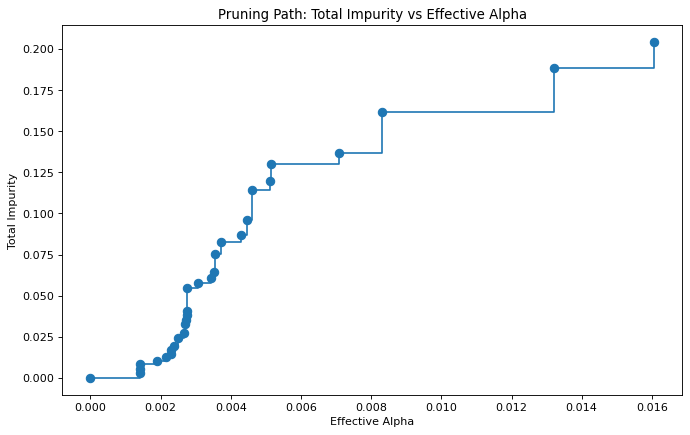

In [86]:
path = dt_clf.cost_complexity_pruning_path(X_train, y_train)

# Extract the values of alpha and total impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity")
plt.title("Pruning Path: Total Impurity vs Effective Alpha")
plt.show()

### Task 12 

Inside of pruning path during (in the output of `cost_complexity_pruning_path`), we have different applicable alpha values and corresponding impurity in the leaf nodes introduced. This contains two Numpy Arrays of alpha and impurities in general. Using the obtained values, 

- Simply plot that relationship based on alpha and corresponding impurity values

- Find an optimal value of alpha by using the model accuracy (looking at the test data performance mainly)

- With this selected alpha value, consider RandomForestClassifier rather than the DecisionTreeClassifier to create a new ensemble model

- Calculate the variable importance by using `feature_importances_` and visualize. You can benefit from the example given here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
#!jupyter nbconvert --to pdf mlp_week08.ipynb 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>